# Etude de l'atmosphère terrestre

__But :__ étudier les variations de température et de pression dans l'atmosphère.

## Position du problème
### Modélisation de l'atmosphère
Dans le cadre du modèle ISA (International Standard Atmosphere), l'atmosphère est divisée en différentes couches, au sein desquelles la température est supposée suivre une [loi affine](https://fr.wikipedia.org/w/index.php?title=Atmosphère_normalisée&oldid=181118275). La valeur du gradient vertical de température dans chacune de ces couches est normalisée.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Pour l'affichage des données
"""Données normalisées pour chaque couche de l'atmosphère.
Vous pourrez utiliser ces vecteurs par la suite.
"""

couche = ["Troposphère", "Tropopause", "Stratosphère", "Stratosphère", "Stratopause", "Mesosphère", "Mesosphère", "Mesopause"]
altitude = [0, 11, 20, 32, 47, 51, 71, 85]
gradient = [- 6.5, 0, + 1.0, + 2.8, 0, - 2.8, - 2.0, "NA"]  # Attention il faudrait traiter le dernier élément qui n'est pas un nombre.

"""Affichage des données
La syntaxe utilisée n'est pas à connaître.
"""
datas = pd.DataFrame({
    "Couche atmosphérique" : couche,
    "Altitude de la base (km)" : altitude,
    "Gradient thermique vertical (K/km)" : ["{:.1f}".format(i)  if type(i)==float else i for i  in gradient]
})

datas.style

,Couche atmosphérique,Altitude de la base (km),Gradient thermique vertical (K/km)
0,Troposphère,0,-6.5
1,Tropopause,11,0
2,Stratosphère,20,1.0
3,Stratosphère,32,2.8
4,Stratopause,47,0
5,Mesosphère,51,-2.8
6,Mesosphère,71,-2.0
7,Mesopause,85,NA


On propose ici de déterminer numériquement la loi de variation de la pression atmosphérique avec l'altitude $z$ dans le cadre du modèle ISA, en supposant que l'atmosphère est __un gaz parfait au repos__ dans le référentiel terrestre galiléen et en négligeant les variations de la pesanteur avec l'altitude. On fixe les valeurs de la température et de la pression au niveau du sol (en z = 0) respectivement à :

$$
\begin{cases}
T_{sol} &= 288 K\\
P_{sol} &= 1.013 \times 10^5 Pa
\end{cases}
$$

On utilisera les données obtenues pour étudier les  mouvements d'un ballon sonde.

#### Données numériques
On prend :
\begin{align}
\textrm{Accélération de la pesanteur} &:& g = 9.81 m.s^{-2}\\
\textrm{Masse molaire de l'air} &:& M_{air} = 29 g.mol^{-1}\\
\textrm{Constante des gaz parfaits} &:& R = 8.314 J.K^{-1}.mol^{-1}
\end{align}

### Mise en équation
On dispose de deux fonctions à intégrer : $T(z)$ et $P(z)$ de deux équations : le modèle affine par morceaux de la température et l'équation de la statique des fluides appliquées à un gaz parfait. Il vient le système (on note le gradient $k_{ISA}$ de température) :

$$
\begin{cases}
\frac{\rm{d}T}{\rm{dz}}(z) &= k_{ISA}(z) \\
\frac{\rm{d}P}{\rm{dz}}(z) &= - {M_{air} g \over RT(z)} \times P(z)
\end{cases}
$$

avec 
$$
\begin{cases}
T(z = 0) &= T_{sol} \\
P(z = 0) &= P_{sol}
\end{cases}
$$

### Schéma d'Euler explicite
On utilise un schéma d'Euler explicite pour le vecteur :
$$Y(z) = \begin{cases}T(z) \\ P(z) \end{cases}$$

Pour un pas d'intégration $h$ et une suite de valeurs $Y_k$ aux altitudes $z_k$, on utilisera la relation de récurrence :

$$
Y_k{k+1} = Y_k + h \times F(z_k, Y_k)
$$

## Détermination du profil de pression et température

> __Exercice 1 :__  
> 1. Ecrire une fonction `kISA` qui prend comme argument une altitude `z` et qui renvoie le gradient de température $k_{ISA}(z)$ associé. Pensez à utiliser les listes définies au début.
> 2. Ecrire une fonction `F_atm(z, Y)` qui prend comme argument l'altitude `z` et le vecteur `Y`$=[T(z), P(z)]$ et qui renvoie la fonction `F` définie précédemment pour ces valeurs. _On rappelle que `F` doit être un __vecteur__._
> 3. Ecrire une fonction `euler(F, pas, Y0, zf)` qui implémente le schéma d'Euler explicite pour une fonction `F` avec un `pas` d'intégration, des conditions aux limites données par le vecteur `Y0`  en $z=0$ et l'altitude finale de l'intégration `zf`. Elle doit renvoyer un vecteur donnant les altitudes de calcul et un tableau à deux colonnes donnant les solutions $[T_k, P_k]$.
> 4. Utiliser la fonction précédente pour obtenir le profil de température et de pression dans l'atmosphère pour le modèle ISA.
> 5. Tracer deux deux graphiques les profils $T(z)$ et $P(z)$.

In [2]:
"""Les bibliothèques scientifiques ont déjà été importées"""

g = 9.81
Mair = 29e-3
Tsol = 288
Psol = 1.013e5
R = 8.314

def kISA(z):
    n = len(altitude)
    """Fonction renvoyant le gradient de température pour une altitude z"""
    for i in range(len(altitude) - 1):  # On va parcourir les couches de l'atmosphère
        if  z < (altitude[i + 1] * 1e3): # Altitude inférieure au début de la couche suivante
            return gradient[i]
    return 0  # Uniquement pour retourner une valeur si on est dans la mésopause mais en pratique, on arrêtera l'intégration avant.


def F_atm(z, Y):
    """Fonction F pour le schéma d'Euler explicite"""
    k = kISA(z) *1e-3 # Gradient à l'altitude z
    return np.array([k, - Mair * g / (R * Y[0]) * Y[1]])


def euler(F, pas, Y0, zf):
    """Implémentation du schéma d'Euler explicite"""
    N = int(zf / pas)  # Nombre de points de calcul
    z = np.zeros(N)  # Vecteur des altitudes
    Y = np.zeros((N, 2))  # Tableau pour stocker les valeurs de l'intégration
    Y[0] = Y0  # Conditions aux limites
    z[0] = 0  # Altitude initiale
    for i in range(1, N):
        dY = F_atm(z[i - 1], Y[i - 1])
        z[i] = z[i - 1] + pas
        Y[i] = Y[i - 1] + pas * dY
    return z, Y


"""Champs de pression et température"""
pas = 1  # On prend un pas de 1m (on est en km)
zf = 85e3  # On s'arrête à la mésopause puisque le gradient n'est pas donné après (limite vraisemblable de l'atmosphère)
z, TP = euler(F_atm, pas, [Tsol, Psol], zf)

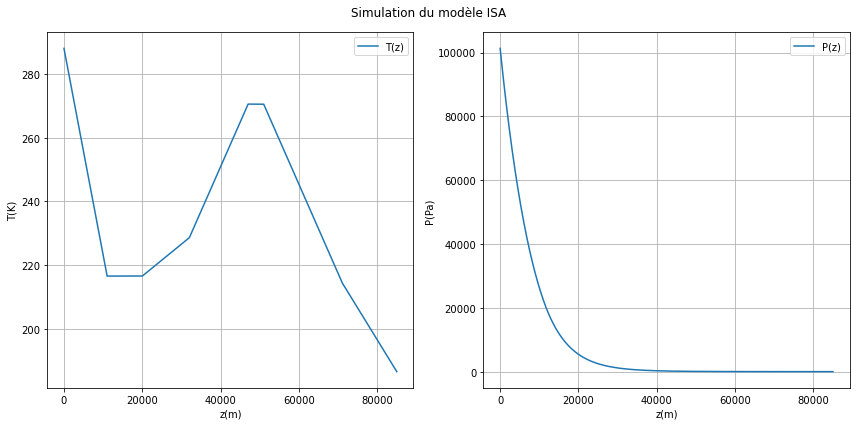

In [3]:
"""Tracé graphique"""
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle("Simulation du modèle ISA")
ax[0].set_xlabel("z(m)")
ax[0].set_ylabel("T(K)")
ax[0].plot(z, TP[:, 0], label="T(z)")
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel("z(m)")
ax[1].set_ylabel("P(Pa)")
ax[1].plot(z, TP[:, 1], label="P(z)")
ax[1].legend()
ax[1].grid()

f.tight_layout()
plt.show()

> __Exercice 2 :__  
> 1. Reprednre l'exercice précédent mais en utilisant la fonction `odeint` dela bibliothèque `scipy.integrate`

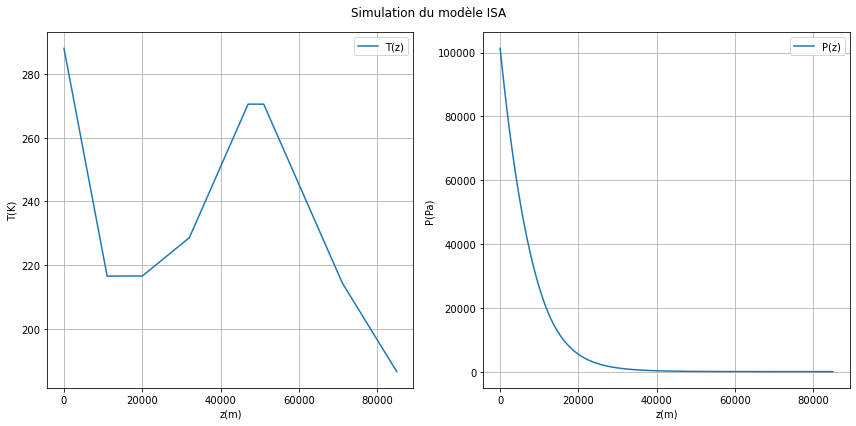

In [4]:
from scipy.integrate import odeint

TP = odeint(F_atm, [Tsol, Psol], z, tfirst=True)

"""Tracé graphique"""
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle("Simulation du modèle ISA")
ax[0].set_xlabel("z(m)")
ax[0].set_ylabel("T(K)")
ax[0].plot(z, TP[:, 0], label="T(z)")
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel("z(m)")
ax[1].set_ylabel("P(Pa)")
ax[1].plot(z, TP[:, 1], label="P(z)")
ax[1].legend()
ax[1].grid(which='both', axis='both')

f.tight_layout()
plt.show()

## Dimensionnement d'un ballon-sonde atmosphérique
Les ballons-sonde stratosphériques constituent une solution simple et relativement économique pour envoyer une charge dans l'atmosphère. Équipés de capteurs divers, ils peuvent par exemple permettre de relever les valeurs de la pression, de la température, de l'humidité ou encore devitesse du vent dans les différentes couches de l'atmosphère traversées

### Position du problème

On considère ici un ballon-sonde stratosphérique "ouvert", constitué d'une enveloppe de volume $V$ ouverte sur l'extérieur par des manches d'évacuation situées à la base du ballon. Au moment du lancement, le ballon est gonflé à l'hélium ($M_{He} = 4,0 g.mol^{-1}$) ; l'enveloppe garde un volume constant tout au long de l'ascension. Le ballon étant ouvert à sa base, la pression à l'intérieur du ballon est identique à tout moment à la pression atmosphérique. La masse de l'ensemble { enveloppe (hors hélium) + nacelle + instruments embarqués } est $m = 10 kg$.

> __Exercice 2 :__
> On souhaite que le ballon atteigne une altitude $z_{max}$ choisie.
> 1. Estimer le volume $V$ de l'enveloppe qui permet d'atteindre cette altitude puis le diamètre du ballon associé.
> Vous devrez :
> * Préciser la modélisation et le paramétrage du problème. On discutera notamment des hypothèses choisies.
> * Tracer V et d en fonction de$z_{max}$.
> * Estimer V et d pour $z_{max} = 36 km$. Commenter la possibilité pour des amateurs de réaliser un tel ballon.

__Hypothèses d'étude :__
* L'hélium sera considéré comme un gaz parfait en équilibre thermique permanent avec l'atmosphère.
* On considère le ballon suffisamment petit pour pouvoir supposer la température et la pression uniforme à l'échelle du ballon.
* Le volume de la nacelle et des autres éléments seront négligeables devant le volume du ballon.

On reviendra sur la troisième hypothèse par la suite. Le gradient de température variant sur des kilomèrte la seconde est plutôt acceptable pour un ballon allant jusqu'à 100m de diamètre (!). La première est relativement acceptable si l'on suppose le ballon à l'équilibre à l'altitude $z$.

__Détermination théorique du volume :__
Le principe fondamental de la dynamique appliqué au ballon à l'équilibre donne suivant l'axe vertical:

$$
\Pi_A + P = 0 = m_{air, depl} g - (m + m_Helium)g
$$

En négligeant le volume de la nacelle, il vient que $V_{air, depl} \approx V_{Helium} = V(z)$ et les deux étant des gaz parfaits à la température $T(z)$ et à la pression $P(z)$, il vient :

$$
V(z) = \frac{mR}{M_{air} - M_{He}}\frac{T(z)}{P(z)}
$$

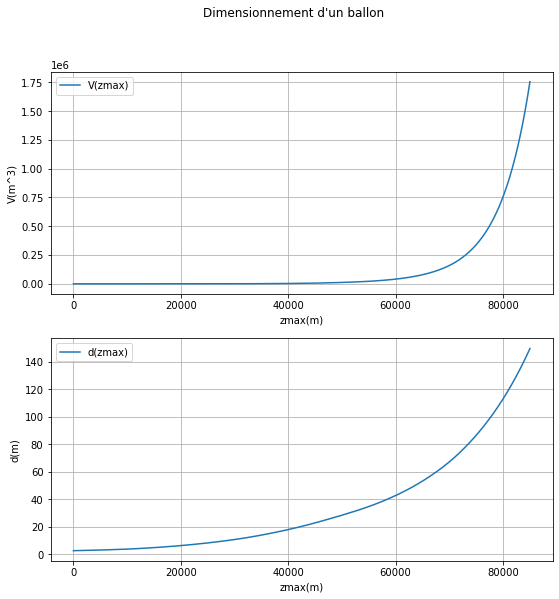

-------------------
Volume d'enveloppe nécessaire : 1666.4 m^3
Diamètre correspondant : 14.71 m
-------------------


In [5]:
m = 10
MHe = 4e-3

"""On dispose des températures et pressions aux altitudes z.
On va calculer V(z) à ces altitudes."""

V = m * R / (Mair - MHe) * (TP[:, 0] / TP[:, 1])  # Volumes
d = 2 * (3 * V / (4 * np.pi)) ** (1/3)  # Diamètre

"""
Tracé graphique
"""
f, ax =plt.subplots(2, 1, figsize=(9, 9))
f.suptitle("Dimensionnement d'un ballon")
ax[0].set_xlabel("zmax(m)")
ax[0].set_ylabel("V(m^3)")
ax[0].plot(z, V, label="V(zmax)")
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel("zmax(m)")
ax[1].set_ylabel("d(m)")
ax[1].plot(z, d, label="d(zmax)")
ax[1].legend()
ax[1].grid()

plt.show()


"""Pour zmax=36km"""
zmax=36e3

"""Recherche par dichotomie de zmax"""
ga, dr = 0, len(z)- 1  # On commence par les indice extrêmes de la liste des altitudes
while dr-ga > 1:  # Tant qu'on a pas unicité de l'indice
    m = (dr + ga) // 2  # Division entière
    if z[m] == zmax:  # On a trouver exactement la valeur
        ga, dr = m, m
    elif z[m] > zmax:
        dr = m 
    else:
        ga = m

V36 = V[m]
d36 = d[m]
print("-------------------")
print("Volume d'enveloppe nécessaire : {:.1f} m^3".format(V36))
print("Diamètre correspondant : {:.2f} m".format(d36))
print("-------------------")

* Assez logiquement, le volume d'hélium fortement quand l'atmosphère se raréfie (il faut composer le poids de la nacelle par beaucoup de gaz léger).
* Dans la zone considérer, le diamètre ne dépasse pas les 150m, l'hypothèse d'un ballon de taille relativement faible pour négliger les variations de T et P reste donc valable. A plus forte raison à 36km où le ballon n'a pas besoin de faire plus 15m de large.

## Complément
> __Exercice 4 :__  
> Si le temps le permet, reprendre l'intégration du système mais en tenant compte des variation du champ de pesanteur avec l'altitude en assimilant ce dernier au champ de gravitation terrestre.  
> Vous représenterez les champs de pression pour les deux modèles (champ de pesanteur uniforme et non uniforme) ainsi que le tracé de l'écart relatif entre les deux modèles en fonction de l'altitude.

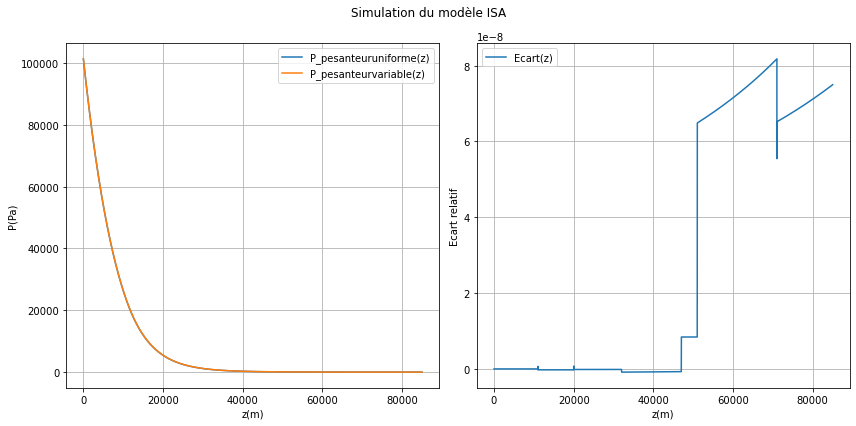

In [6]:
def pesanteur(z):
    """Renvoie le champ de pesanteur assimilé au champ de gravitation à une altitude z"""
    RT = 6400e3
    return g * (RT / (RT + z)) ** 2


def F_atm2(z, Y):
    """Fonction F pour le schéma d'Euler explicite"""
    k = kISA(z) *1e-3 # Gradient à l'altitude z
    return np.array([k, - Mair * pesanteur(z) / (R * Y[0]) * Y[1]])


TP2 = odeint(F_atm2, [Tsol, Psol], z, tfirst=True)

"""Tracé graphique"""
f, ax = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle("Simulation du modèle ISA")

ax[0].set_xlabel("z(m)")
ax[0].set_ylabel("P(Pa)")
ax[0].plot(z, TP[:, 1], label="P_pesanteuruniforme(z)")
ax[0].plot(z, TP2[:, 1], label="P_pesanteurvariable(z)")
ax[0].legend()
ax[0].grid(which='both', axis='both')

ax[1].set_xlabel("z(m)")
ax[1].set_ylabel("Ecart relatif")
ax[1].plot(z, (TP[:, 0] - TP2[:, 0]) / TP[:, 0], label="Ecart(z)")
ax[1].legend()
ax[1].grid()

f.tight_layout()
plt.show()

On observe une écart très faible de l'ordre de $10^{-6}$% : l'hypothèse de champ de pesanteur uniforme sur 85km était donc largement acceptable.